In [1]:
import requests
import io
import re
import json
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import gsw
import seaborn as sns

In [2]:
sns.set_context("talk", rc = {"lines.linewidth":2.5, "font.family": "Arial"})

In [3]:
### ACCESS N2O DATA ###
# GO-SHIP P18, Kelly et al., in review (https://doi.org/10.21203/rs.3.rs-6378208/v1)
goshipp18 = "https://cchdo.ucsd.edu/data/42947/33RO20161119_hy1.csv"
# check that merged file online on CCHDO matches local data
rawdata = requests.get(goshipp18)
p18online = pd.read_csv(io.StringIO(rawdata.content.decode('utf-8')), comment = '#', skiprows=1)

# Force columns to be numeric, coerce errors to NaN if needed
alphanumerics = ['EXPOCODE', 'SECT_ID']
for c in p18online.columns:
    if c not in alphanumerics:
        p18online[c] = pd.to_numeric(p18online[c], errors='coerce')

p18online = p18online[(p18online.EXPOCODE=='33RO20161119  ')&(p18online.N2O != -999)&(p18online.N2O != np.nan)]

# remove bad-flagged data
badflags_btl = [
    1.0, # bottle information unavailable
    3.0, # leaking
    4.0, # did not trip correctly
    5.0, # not reported
    6.0, # significant discrapancy between Gerard and Niskin bottles
    7.0, # unknown problem
    8.0, # pair did not trip correctly
    9.0  # samples not drawn from this bottle
]

badflags_ctd = [
    1.0, # not calibrated
    3.0, # questionable
    4.0, # bad measurement
    5.0, # not reported
    9.0  # not sampled
]

badflags_sample = [
    1.0, # sample was drawn from this bottle but analysis not received
    3.0, # questionable
    4.0, # bad measurement
    5.0, # not reported
    9.0  # sample was not drawn for this measurement, from this bottle
]

btlmask = np.isin(p18online['BTLNBR_FLAG_W'],badflags_btl)
ctdmask = np.isin(p18online['CTDSAL_FLAG_W'], badflags_ctd).max(axis=0) # "max" here means False + True = True
n2omask = np.isin(p18online['N2O_FLAG_W'], badflags_sample)
mask = btlmask + ctdmask + n2omask
p18online = pd.DataFrame(p18online[~mask])

# calculate derived variables and sigma-T
p18online['SA'] = gsw.SA_from_SP(p18online['CTDSAL'],p18online['CTDPRS'],p18online['LONGITUDE'],p18online['LATITUDE'])
p18online['CT'] = gsw.CT_from_t(p18online['SA'],p18online['CTDTMP'],p18online['CTDPRS'])
p18online["rho"] = gsw.density.rho(p18online['SA'],p18online["CT"], p18online['CTDPRS'])
p18online["SIGMA0"] = gsw.density.sigma0(p18online['SA'],p18online['CT'])
p18online['SOURCE'] = "https://doi.org/10.21203/rs.3.rs-6378208/v1"

p18online['PT'] = gsw.pt0_from_t(p18online['SA'], p18online['CTDTMP'],p18online['CTDPRS'])
p18online["o2sat"] = gsw.O2sol_SP_pt(p18online['CTDSAL'],p18online['PT'])
p18online["AOU"] = p18online["o2sat"] - p18online["CTDOXY"]

p18online = p18online[p18online.LATITUDE >= 10]

In [16]:
p18online

,EXPOCODE,SECT_ID,STNNBR,CASTNO,SAMPNO,BTLNBR,BTLNBR_FLAG_W,DATE,TIME,LATITUDE,...,D15N_N2_FLAG_W,D15N_N2_ERROR,SA,CT,rho,SIGMA0,SOURCE,PT,o2sat,AOU
2,33RO20161119,P18,1.0,3.0,23.0,11121.0,2.0,20161124.0,1417.0,22.6884,...,9.0,-999.0,34.683357,27.912545,1022.176981,22.071642,https://doi.org/10.21203/rs.3.rs-6378208/v1,27.887131,197.814317,3.014317
3,33RO20161119,P18,1.0,3.0,22.0,11120.0,2.0,20161124.0,1417.0,22.6884,...,9.0,-999.0,34.346140,21.336770,1024.049948,23.791372,https://doi.org/10.21203/rs.3.rs-6378208/v1,21.315434,221.470233,2.070233
4,33RO20161119,P18,1.0,3.0,21.0,11119.0,2.0,20161124.0,1417.0,22.6884,...,9.0,-999.0,33.909771,14.729775,1025.517524,25.075658,https://doi.org/10.21203/rs.3.rs-6378208/v1,14.709633,251.366909,77.566909
6,33RO20161119,P18,1.0,3.0,19.0,11083.0,2.0,20161124.0,1417.0,22.6884,...,9.0,-999.0,34.779996,12.277713,1027.059738,26.240708,https://doi.org/10.21203/rs.3.rs-6378208/v1,12.280298,262.436659,245.536659
7,33RO20161119,P18,1.0,3.0,18.0,11117.0,2.0,20161124.0,1417.0,22.6884,...,9.0,-999.0,34.765642,11.190420,1027.511050,26.433585,https://doi.org/10.21203/rs.3.rs-6378208/v1,11.193055,268.482024,254.882024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,33RO20161119,P18,29.0,1.0,5.0,11104.0,2.0,20161201.0,1028.0,10.0001,...,9.0,-999.0,34.837896,1.842311,1037.811259,27.723565,https://doi.org/10.21203/rs.3.rs-6378208/v1,1.842469,332.781753,232.281753
680,33RO20161119,P18,29.0,1.0,4.0,11103.0,2.0,20161201.0,1028.0,10.0001,...,9.0,-999.0,34.844418,1.725536,1039.022431,27.737731,https://doi.org/10.21203/rs.3.rs-6378208/v1,1.725641,333.745332,227.645332
681,33RO20161119,P18,29.0,1.0,3.0,11102.0,2.0,20161201.0,1028.0,10.0001,...,9.0,-999.0,34.849966,1.637881,1040.173925,27.748775,https://doi.org/10.21203/rs.3.rs-6378208/v1,1.637949,334.469825,223.969825
682,33RO20161119,P18,29.0,1.0,2.0,11101.0,2.0,20161201.0,1028.0,10.0001,...,9.0,-999.0,34.855968,1.501661,1041.571149,27.763657,https://doi.org/10.21203/rs.3.rs-6378208/v1,1.501651,335.607514,215.507514


In [5]:
# Kelly et al., 2021 (https://doi.org/10.1029/2020GB006637)
kelly2021url = "https://stacks.stanford.edu/file/tn058yj9865/200413%20nitrous%20oxide%20cycling%20regimes%20data%20for%20repositories-1.xlsx"
rawdata = requests.get(kelly2021url)
# io.BytesIO is used instead of io.StringIO because Excel files are binary.
kelly2021 = pd.read_excel(io.BytesIO((rawdata.content)))
# Optionally clean column names to remove or replace symbols
kelly2021.columns = kelly2021.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
kelly2021["EXPOCODE"] = "SR1805"

# remove bad-flagged data
mask = np.isin([
    kelly2021['N2O_Flag_1'],
    kelly2021['N2O_Flag_2'],
               ],
               badflags_sample).max(axis=0) # "max" here means False + True = True

kelly2021 = pd.DataFrame(kelly2021[~mask])

# rename columns
columnnames = {
    'Station':'STNNBR',
    'Cast':'CASTNO',
    'Niskin_':'BTLNBR',
    'Sample_ID':'SAMPNO',
    'Time_local_':'TIME',
    'Latitude_N_':"LATITUDE",
    'Longitude_degrees_east_':"LONGITUDE",
    'CTD_Pressure_db_':'CTDPRS',
    'Salinity_psu_':'CTDSAL',
    'Temperature_C_':'CTDTMP',
    'Seabird_Oxygen_umol_L_':'CTDOXY',
    'NO3_mean_uM_':'NITRAT',
    'NO3_std_uM_':'NITRAT_sd',
    'Nitrite_uM_':'NITRIT'}

kelly2021.rename(columns = columnnames, inplace=True)

# calculate derived variables and sigma-T
kelly2021['SA'] = gsw.SA_from_SP(kelly2021['CTDSAL'],kelly2021['CTDPRS'],kelly2021['LONGITUDE'],kelly2021['LATITUDE'])
kelly2021['CT'] = gsw.CT_from_t(kelly2021['SA'],kelly2021['CTDTMP'],kelly2021['CTDPRS'])
kelly2021["rho"] = gsw.density.rho(kelly2021['SA'],kelly2021["CT"], kelly2021['CTDPRS'])
kelly2021["SIGMA0"] = gsw.density.sigma0(kelly2021['SA'],kelly2021['CT'])

# convert N2O in nmol/L to nmol/kg
kelly2021["N2O"] = kelly2021['N2O_mean_nM_']/kelly2021["rho"]*1000

# convert seabird oxygen from umol/L to umol/kg
kelly2021['CTDOXY'] = kelly2021['CTDOXY']/kelly2021["rho"]*1000

# set remaining N2O data flags to 2
kelly2021["N2O_FLAG_W"] = 2.0

kelly2021['SOURCE'] = "https://doi.org/10.1029/2020GB006637"

kelly2021['PT'] = gsw.pt0_from_t(kelly2021['SA'], kelly2021['CTDTMP'],kelly2021['CTDPRS'])
kelly2021["o2sat"] = gsw.O2sol_SP_pt(kelly2021['CTDSAL'],kelly2021['PT'])
kelly2021["AOU"] = kelly2021["o2sat"] - kelly2021["CTDOXY"]

/Users/colette/anaconda3/envs/py310_oceml/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
kelly2021

,STNNBR,CASTNO,Target_Depth_m_,BTLNBR,TIME,Time_GMT_,LATITUDE,Longitude_W_,LONGITUDE,CTDPRS,...,SA,CT,rho,SIGMA0,N2O,N2O_FLAG_W,SOURCE,PT,o2sat,AOU
0,PS1,2,220,12.0,1650.0,2350.0,10.00002,113.00082,-112.999833,225.443,...,34.927116,11.488236,1027.509660,26.503241,87.397520,2.0,https://doi.org/10.1029/2020GB006637,11.494082,266.484280,259.207462
1,PS1,2,300,10.0,1650.0,2350.0,10.00002,113.00082,-112.999833,306.489,...,34.877771,10.513585,1028.014558,26.641194,66.565207,2.0,https://doi.org/10.1029/2020GB006637,10.518496,272.128755,266.699844
2,PS1,2,400,9.0,1650.0,2350.0,10.00002,113.00084,-112.999833,406.454,...,34.801382,9.104729,1028.651167,26.819179,62.365233,2.0,https://doi.org/10.1029/2020GB006637,9.108192,280.699667,277.976684
3,PS1,2,500,8.0,1650.0,2350.0,10.00002,113.00084,-112.999833,506.960,...,34.729081,7.701310,1029.277161,26.978218,61.096138,2.0,https://doi.org/10.1029/2020GB006637,7.703415,289.733702,285.939778
4,PS1,2,600,7.0,1650.0,2350.0,10.00002,113.00084,-112.999833,607.990,...,34.715868,6.649194,1029.884445,27.115228,69.067444,2.0,https://doi.org/10.1029/2020GB006637,6.650871,296.767832,292.638242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,T6,68,600,5.0,730.0,1230.0,17.33190,102.80880,-102.808667,605.447,...,34.719921,6.894101,1029.839322,27.085194,31.523067,2.0,https://doi.org/10.1029/2020GB006637,6.895899,295.103166,292.335744
214,T6,68,800,4.0,730.0,1230.0,17.33186,102.80884,-102.808667,806.728,...,34.716856,5.540775,1030.946059,27.257885,88.954959,2.0,https://doi.org/10.1029/2020GB006637,5.542093,304.491693,301.146222
215,T6,68,1000,3.0,730.0,1230.0,17.33192,102.80884,-102.808667,1008.358,...,34.727512,4.543180,1032.006952,27.381979,83.019675,2.0,https://doi.org/10.1029/2020GB006637,4.544175,311.735622,302.282197
216,T6,68,1250,2.0,730.0,1230.0,17.33188,102.80882,-102.808667,1262.076,...,34.754021,3.618805,1033.302114,27.499752,65.421247,2.0,https://doi.org/10.1029/2020GB006637,3.619556,318.690631,288.914248


In [7]:
# Monreal et al., 2022
monreal2022url = "https://stacks.stanford.edu/file/hw279tj6064/211209_ETNP16_Manuscript_DatasetForStanfordRepository.csv"
rawdata = requests.get(monreal2022url)
# csv file encoded in ISO-8859-1 (Latin-1)
monreal2022 = pd.read_csv(io.StringIO(rawdata.content.decode('latin1')))


# Clean up column names (replace symbols with underscores)
monreal2022.columns = monreal2022.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# rename columns
columnnames = {
    'Cruise':'EXPOCODE',
    'Date_mdy_':'DATE',
    'Station_':'STNNBR',
    'Cast_':'CASTNO',
    'Niskin_':'BTLNBR',
    'Sample_ID':'SAMPNO',
    'Time_local_':'TIME',
    'Latitude_Degrees_North_':"LATITUDE",
    'Longitude_Degrees_East_':"LONGITUDE",
    'Pressure_dB_':'CTDPRS',
    'Salinity_psu_':'CTDSAL',
    'Temperature_degrees_Celsius_':'CTDTMP',
    '_O2_umol_kg_':'CTDOXY',
    '_NO3_uM_':'NITRAT',
    '_NO2_uM_':'NITRIT'}

monreal2022.rename(columns = columnnames, inplace=True)

# calculate derived variables and sigma-T
monreal2022['SA'] = gsw.SA_from_SP(monreal2022['CTDSAL'],monreal2022['CTDPRS'],monreal2022['LONGITUDE'],monreal2022['LATITUDE'])
monreal2022['CT'] = gsw.CT_from_t(monreal2022['SA'],monreal2022['CTDTMP'],monreal2022['CTDPRS'])
monreal2022["rho"] = gsw.density.rho(monreal2022['SA'],monreal2022["CT"], monreal2022['CTDPRS'])
monreal2022["SIGMA0"] = gsw.density.sigma0(monreal2022['SA'],monreal2022['CT'])

# convert N2O in nmol/L to nmol/kg
monreal2022["N2O"] = monreal2022['_N2O_nM_']/monreal2022["rho"]*1000

# set remaining N2O data flags to 2
monreal2022["N2O_FLAG_W"] = 2.0

monreal2022["SOURCE"] = "https://doi.org/10.1029/10.1029/2022GB007310"

monreal2022['PT'] = gsw.pt0_from_t(monreal2022['SA'], monreal2022['CTDTMP'],monreal2022['CTDPRS'])
monreal2022["o2sat"] = gsw.O2sol_SP_pt(monreal2022['CTDSAL'],monreal2022['PT'])
monreal2022["AOU"] = monreal2022["o2sat"] - monreal2022["CTDOXY"]

In [8]:
cols = list(set(list(p18online.columns))& set(list(kelly2021.columns))&set(list(monreal2022.columns)))

df = pd.concat([p18online[cols],
           kelly2021[cols],
           monreal2022[cols],
                ])

df["DEPTH"] = -gsw.z_from_p(df.CTDPRS, df.LATITUDE)
df.to_csv("mergedn2o.csv")

In [9]:
### ACCESS WORLD OCEAN ATLAS O2, T, AND S DATA ###
woa_o2_url = "https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/oxygen/netcdf/all/1.00/woa23_all_o00_01.nc"
woaO2 = xr.open_dataset(woa_o2_url, decode_times=False)
woaO2 = woaO2.sel(lat = slice(4,26), lon = slice(-121,-99)).drop_vars(['time', 'climatology_bounds'])

woa_T_url = "https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/temperature/netcdf/decav/1.00/woa23_decav_t00_01.nc"
woaT = xr.open_dataset(woa_T_url, decode_times=False)
woaT = woaT.sel(lat = slice(4,26), lon = slice(-121,-99)).drop_vars(['time', 'climatology_bounds'])

woa_S_url = "https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/salinity/netcdf/decav/1.00/woa23_decav_s00_01.nc"
woaS = xr.open_dataset(woa_S_url, decode_times=False)
woaS = woaS.sel(lat = slice(4,26), lon = slice(-121,-99)).drop_vars(['time', 'climatology_bounds'])

woa = xr.merge([woaO2, woaT, woaS])

# Compute pressure
P = gsw.p_from_z(-woa.depth, woa.lat)  # depth to pressure (z is negative)
P = xr.DataArray(P, dims=["depth", "lat"], coords={"depth": woa.depth, "lat": woa.lat})
woa["P"] = P

# calculate derived variables and sigma-T
woa['SA'] = gsw.SA_from_SP(woa.s_an,woa.P,woa.lon,woa.lat)
woa['CT'] = gsw.CT_from_t(woa.s_an,woa.t_an,woa.P)
woa["rho"] = gsw.density.rho(woa.s_an,woa['CT'], woa.P)
woa["SIGMA0"] = gsw.density.sigma0(woa['SA'],woa['CT'])

woa['PT'] = gsw.pt0_from_t(woa['SA'], woa.t_an, woa.P)
woa["o2sat"] = gsw.O2sol_SP_pt(woa.s_an,woa['PT'])
woa["AOU"] = woa["o2sat"] - woa.o_an

# Find index of depth level closest to sigma-theta = 26.5
sigma_mask = (woa.SIGMA0 >= 26) & (woa.SIGMA0 <= 27)

# Apply mask to extract O2 and N2O in that density range
o2_sigma_filtered = woa.o_an.where(sigma_mask)
# take mean across depth if multiple layers match
o2_at_sigma_25 = o2_sigma_filtered.mean(dim="depth", skipna=True)

In [10]:
# Select data at sigma_theta = 25 ± 0.5
target_sigma = 25
tolerance = 0.5
subset = df[np.abs(df['SIGMA0'] - target_sigma) < tolerance]
subset = subset.groupby(["LATITUDE","LONGITUDE"]).max().reset_index()

In [33]:
# select N2O concentrations at peak
peakdepths = pd.DataFrame()
stationlist = df[['EXPOCODE','STNNBR']].drop_duplicates()

for i in range(len(stationlist)):
    e = stationlist.iloc[i].EXPOCODE
    s = stationlist.iloc[i].STNNBR
    maxn2o = df[(df.EXPOCODE == e)&(df.STNNBR == s)].N2O.max()
    peakdepth = df[(df.EXPOCODE == e)&(df.STNNBR == s)&(df.N2O == maxn2o)]
    peakdepths =  pd.concat([peakdepths,peakdepth])

peakdepths = peakdepths.sort_values("N2O")

In [35]:
# set up plotting main stations
ps1 = df[df.STNNBR == "PS1"][["LATITUDE", "LONGITUDE"]].mean()
ps2 = df[df.STNNBR == "PS2"][["LATITUDE", "LONGITUDE"]].mean()
ps3 = df[df.STNNBR == "PS3"][["LATITUDE", "LONGITUDE"]].mean()

mainstations = peakdepths[(peakdepths.STNNBR == "PS1") | (peakdepths.STNNBR == "PS2") | (peakdepths.STNNBR == "PS3")]

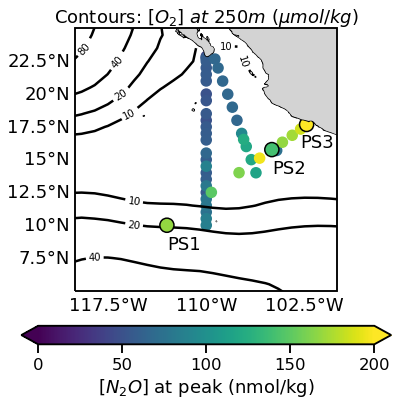

In [38]:
# grab WOA data at 250m
woasubset = woaO2.sel(depth = slice(240,260))

woa_o2 = woasubset.o_an.values[0,0,:,:]
woa_lat = woasubset.lat.values[:]
woa_lon = woasubset.lon.values[:]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-120, -100, 5, 25], crs=ccrs.PlateCarree())

g = ax.gridlines(linestyle='--',zorder=5, draw_labels=True)
g.top_labels = False     # Turn off top labels
g.right_labels = False   # Turn off right labels
g.xlines = False
g.ylines = False

cax = ax.scatter(peakdepths.LONGITUDE, peakdepths.LATITUDE,
                 c = peakdepths.N2O,
                 vmin=0, vmax = 200,
                 s = 100, zorder = 0)

# plot main stations larger and with black border
ax.scatter(mainstations.LONGITUDE, mainstations.LATITUDE,
           c = mainstations.N2O, edgecolor = "k",
           vmin=0, vmax = 200,
           s=200, zorder = 2)

cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', pad=0.1,
                    extend='both', 
                    #ticks = [i for i in np.arange(300,600,50)]
                   )
cbar.set_label('$[N_2O]$ at peak (nmol/kg)')

# plot O2 at 250m
#contourlevs = np.arange(5, 100, 5)
contourlevs = [10,20,40,80]
cs = ax.contour(woa_lon, woa_lat, woa_o2, levels=contourlevs, colors='k', transform=ccrs.PlateCarree(), zorder = 1)
ax.clabel(cs, fmt='%d', colors='k', zorder = 1, fontsize = 10)

# Title
ax.set_title('Contours: $[O_2]\ at\ 250m\ (\mu mol/kg)$')

# station labels
ax.text(ps1.LONGITUDE, 9.25, "PS1",
       horizontalalignment = "left", verticalalignment = "top")
ax.text(ps2.LONGITUDE, 15, "PS2",
       horizontalalignment = "left", verticalalignment = "top")
ax.text(ps3.LONGITUDE*1.005, 17, "PS3",
       horizontalalignment = "left", verticalalignment = "top")

ax.coastlines(resolution='10m', zorder = 2)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder = 2)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder = 2)

plt.tight_layout()
plt.savefig("contourfig_v1.pdf")
plt.show()

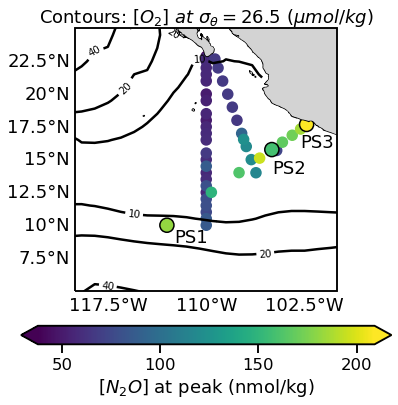

In [45]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-120, -100, 5, 25], crs=ccrs.PlateCarree())

g = ax.gridlines(linestyle='--',zorder=5, draw_labels=True)
g.top_labels = False     # Turn off top labels
g.right_labels = False   # Turn off right labels
g.xlines = False
g.ylines = False

cax = ax.scatter(peakdepths.LONGITUDE, peakdepths.LATITUDE, c = peakdepths.N2O, s = 100, zorder = 0)

# plot main stations larger and with black border
ax.scatter(mainstations.LONGITUDE, mainstations.LATITUDE,
           c = mainstations.N2O, edgecolor = "k",
           vmin=0, vmax = 200,
           s=200, zorder = 2)

cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', pad=0.1,
                    extend='both', 
                    #boundaries=bounds,
                    #ticks = [i for i in np.arange(300,600,50)]
                   )
cbar.set_label('$[N_2O]$ at peak (nmol/kg)')

# Line contours for O2
contourlevs = [10,20,40,80]
cs = ax.contour(woa.lon, woa.lat,o2_at_sigma_25.values[0,:,:], levels=contourlevs, colors='k', zorder = 1)
ax.clabel(cs, fmt='%d', zorder = 1, fontsize = 10)

ax.coastlines(resolution='10m', zorder = 2)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder = 2)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder = 2)

# Title
ax.set_title('Contours: $[O_2]\ at\ σ_θ=26.5\ (\mu mol/kg)$')

# station labels
ax.text(ps1.LONGITUDE*0.995, 9.75, "PS1",
       horizontalalignment = "left", verticalalignment = "top")
ax.text(ps2.LONGITUDE, 15, "PS2",
       horizontalalignment = "left", verticalalignment = "top")
ax.text(ps3.LONGITUDE*1.005, 17, "PS3",
       horizontalalignment = "left", verticalalignment = "top")

plt.tight_layout()
plt.savefig("contourfig_v2.pdf")
plt.show()